In [2]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. 

In [3]:
MASK_DIR = "data/mask_image"
DATA_DIR="data/fish_image"
IMG_SIZE = 100
LR = 1e-3

MODEL_NAME = 'fishCNN_oct_parallel-{}-{}.model'.format(LR, '2conv-basic')

def createData():
    data=[]
    mask=[]
    for dir in tqdm(os.listdir(DATA_DIR)):
        mask_path = os.path.join(MASK_DIR,dir)
        img_path=os.path.join(DATA_DIR,dir)
        label=dir.split('_')[-1];
        oneHotLabel=np.zeros(23);
        oneHotLabel[int(label)-1]=1;
        for img in tqdm(os.listdir(img_path)):
            path = os.path.join(img_path,img)
            imgData = cv2.imread(path)
            imgData = cv2.resize(imgData, (IMG_SIZE,IMG_SIZE))
            
            
            mpath = os.path.join(mask_path,img)
            mpath=mpath.replace("fish","mask")
            mask= cv2.imread(mpath,cv2.IMREAD_GRAYSCALE)
            
#             print mpath
#             print mask.shape
            mask=cv2.resize(mask,(IMG_SIZE,IMG_SIZE))
            
            imgData=np.dstack((imgData,mask))
            
            data.append([np.array(imgData),np.array(oneHotLabel)])
            
    shuffle(data)
    np.save('data_masked_parallel.npy', data)
    return data

In [4]:
#data=createData()
data=np.load("data_masked_parallel.npy")

In [5]:
data[0][0].shape

(100, 100, 4)

In [59]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 4], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 23, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log_mask')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [60]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /home/sushant/ml/FISHES PROJECT/sj/fishCNN_oct_parallel-0.001-2conv-basic.model
model loaded!


In [8]:
train = data[:-int(len(data)/20)]
test = data[-int(len(data)/20):]


In [9]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,4)
test_y = [i[1] for i in test]

#X.dtype

# X=X.view('float32')
# test_x/=test_x.view('float32')

# test_x
test_x.size

54720000

In [ ]:
#model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

In [ ]:
#model.save(MODEL_NAME)



In [24]:
np.dstack(test_x[5,:,:,np.array([0,1,2])]).shape


(100, 100, 3)

In [10]:
cv2.imshow('fish',X[1,:,:,1:4])

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline

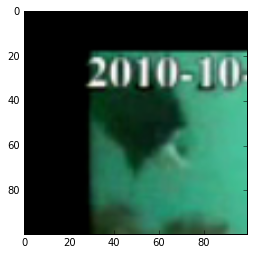

[[  2.96451781e-05   9.37040227e-07   9.99951720e-01   5.16884029e-07
    2.05959798e-11   1.48437651e-10   7.05244079e-16   4.63624827e-09
    4.18176882e-07   4.90873169e-16   1.08135211e-11   1.18101945e-10
    2.22509004e-17   2.27852931e-10   1.67714570e-05   1.03408873e-16
    4.15772729e-14   1.44829171e-09   4.57444411e-17   1.50659108e-13
    4.15780301e-12   7.10773044e-15   3.64978053e-16]]
[[ 2  0 14  1  3  8  7 17 13  5 11  4 10 20 19 16 21  6  9 22 15 18 12]]


In [98]:
n=40

plt.imshow(np.dstack(test_x[n,:,:,np.array([2,1,0])]))
plt.show()
print model.predict([test_x[n]])
print model.predict_label([test_x[n]])

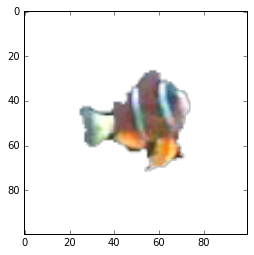

In [57]:
plt.imshow(np.dstack(test_x[n,:,:,np.array([2,1,0,3])]))

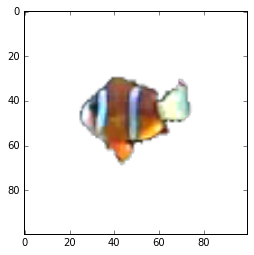

In [108]:
im4=cv2.imread('f4.png')
im4=cv2.resize(im4,(100,100))
ms4=cv2.imread('m4.png',cv2.IMREAD_GRAYSCALE)
ms4=cv2.resize(ms4,(100,100))
c4=np.dstack([im4,ms4])
c4.shape

plt.imshow((c4[:,:,np.array([2,1,0,3])]))

In [110]:
print model.predict([c4])
print model.predict_label([c4])

[[  2.95503760e-10   8.37815423e-06   2.73970863e-12   9.99989867e-01
    9.96165113e-07   2.64806364e-15   2.27682626e-14   1.32584984e-20
    2.93309294e-10   5.57556050e-11   9.47000522e-09   6.33305797e-10
    6.08826838e-07   1.04944398e-16   1.00366464e-07   1.19321986e-09
    7.93853678e-15   5.67490600e-24   2.12937697e-24   1.13227054e-19
    1.94529713e-29   1.04263047e-20   6.20302307e-22]]
[[ 3  1  4 12 14 10 15 11  0  8  9  2  6 16  5 13 19  7 21 22 17 18 20]]
